In [1]:
import numpy as np
import cPickle as pickle
from itertools import groupby
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# calculate accuracy of prediction, indicating how many ground truth
#      labels are predicted
# note a ground truth is l, which is a list of labels, and prediction
#      is p, a list of labels
# the accuracy is definded as (# intersection(l,p))/(# labels in l)
# input: pred - [m lists] a list consists of m lists of labels,
#        label - [m lists] a list consists of m lists of labels
# output: accuracy - [m*1 array] a list of accuracy of prediction
def getAccuracy(pred,label):
    n = len(pred)
    accuracy = []
    for p,l in zip(pred,label):
        p,l = set(p),set(l)
        acc = float(len(l.intersection(p)))/float(len(l))
        accuracy.append(acc)
    return accuracy

# get frequency of labels for each sample data
# input: data - [n lists] a list consists of n lists of [m lists]
# output: - [n lists] a list consists of n lists of [2 lists],
#           of which first list as labels, second list as frequency
def getFrequency(data):
    return map(getFrequencyList,data)

# get frequency of labels except for the last list of labels (prediction)
# input: lists - [m lists] a list consists of m list of labels
# output: frequency - [2 lists] frequency[0] as labels, frequency[1] as frequency
def getFrequencyList(lists):
    frequency = {}
    for l in lists[:-1]:
        for code in l:
            if code in frequency:
                frequency[code] += 1
            else:
                frequency[code] = 1
    
    # sort labels according to [frequency descending, label order]
    frequency = list(frequency.items())
    frequency = sorted(frequency,key = lambda l:(l[1],-l[0]),reverse = True)
    return frequency

# get top K predictions from full set of label prediction
# input: pred - [m lists] a list consists of m 2d lists, the 2d list is 
#               ([label, frequency]) ordered by frequency descending
#        K - [int] select top K predicted labels with high frequency
# output: top_k - [m lists] a list consists of m lists
def getTopK(pred,K=10):
    n = len(pred)
    top_k = []
    for p in pred:
        # get top min(K,len(p)) labels as prediction
        top_k.append(map(lambda x:x[0],p[:min(K,len(p))]))
    return top_k

In [3]:
# load data
test_data = pickle.load(open('../data/test_182','rb'))
test_input = pickle.load(open('../data/test_full','rb'))

In [4]:
# ground truth, the last element of list 
label = map(lambda x:x[-1],test_data)

In [5]:
# prediction, as the second last element of list
prediction_last = map(lambda x:x[len(x)-2],test_input)

accuracy_last = getAccuracy(prediction_last,label)
print 'accuracy of taking last visit as prediction: ',np.mean(accuracy_last)

accuracy of taking last visit as prediction:  0.423450687907


In [6]:
n = len(test_data)
length = map(len,test_data)
# input: accuracy - [n*2 matrix] the first column is the length of the sample,
#                   the second column is the accuracy of prediction
#                   the matrix is ordered by length
# output: stat - [list of (length,(count,average,std))] statistics for each length
def getStatistics(accuracy):
    stat = {}
    for key,group in groupby(accuracy,lambda x:x[0]):
        l = map(lambda x:x[1],group)
        stat[int(key)] = (len(l),np.mean(l),np.std(l))
    stat = sorted(list(stat.items()),key=lambda x:x[0])
    return stat

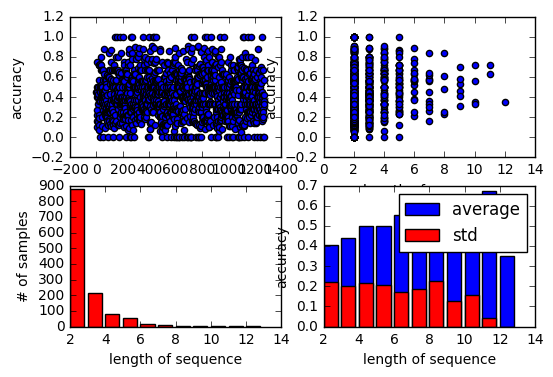

In [8]:
# distribution of accuracy
plt.subplot(2,2,1)
COLOR = ['red','blue','black']
plt.scatter(range(n),accuracy_last)
plt.ylabel('accuracy')

# distribution of accuracy vs length of sequence
plt.subplot(2,2,2)
plt.scatter(length,accuracy_last)
plt.ylabel('accuracy')
plt.xlabel('length of sequence')

# relationship between length of sequence and prediction accuracy
plt.subplot(2,2,3)
length_accuracy = np.asarray([length,accuracy_last]).T
length_accuracy = sorted(length_accuracy,key=lambda x:x[0])

stat = getStatistics(length_accuracy)

file_name = open('../stat/last_visit','wr')
pickle.dump(('last visit',stat),file_name)
file_name.close()

plt.subplot(2,2,3)
plt.bar(map(lambda x:x[0],stat),map(lambda x:x[1][0],stat),color = 'red')
plt.xlabel('length of sequence')
plt.ylabel('# of samples')

plt.subplot(2,2,4)
plt.bar(map(lambda x:x[0],stat),map(lambda x:x[1][1],stat),color = 'blue')
plt.bar(map(lambda x:x[0],stat),map(lambda x:x[1][2],stat),color = 'red')
plt.legend(['average','std'])
plt.xlabel('length of sequence')
plt.ylabel('accuracy')

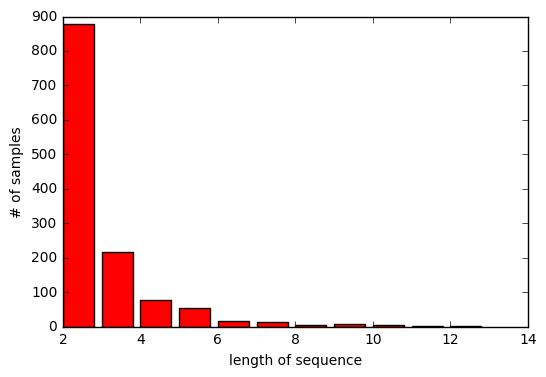

In [9]:
plt.bar(map(lambda x:x[0],stat),map(lambda x:x[1][0],stat),color = 'red')
plt.xlabel('length of sequence')
plt.ylabel('# of samples')

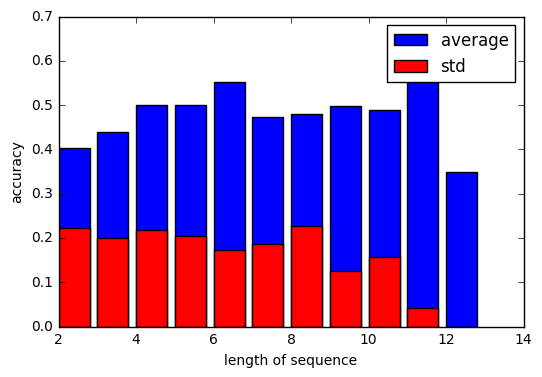

In [10]:
plt.bar(map(lambda x:x[0],stat),map(lambda x:x[1][1],stat),color = 'blue')
plt.bar(map(lambda x:x[0],stat),map(lambda x:x[1][2],stat),color = 'red')
plt.legend(['average','std'])
plt.xlabel('length of sequence')
plt.ylabel('accuracy')

In [11]:
# prediction, as the most frequent labels in the list
frequency = getFrequency(test_input)
TOP_K = [10,20,30] # prediction on TOP_K labels

accuracy_frequent = []
for k in TOP_K:
    prediction_frequent = getTopK(frequency,k)
    accuracy_frequent.append(getAccuracy(prediction_frequent,label))
print 'accurary of taking the top K frequent codes as prediction, with K =',TOP_K
print np.mean(accuracy_frequent,axis =1)

accurary of taking the top K frequent codes as prediction, with K = [10, 20, 30]
[ 0.38324111  0.45346315  0.46602727]


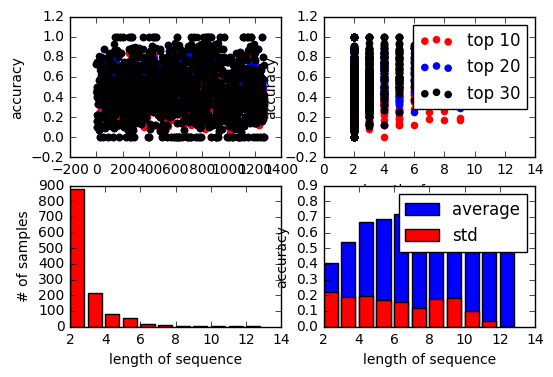

In [12]:
# distribution of accuracy
plt.subplot(2,2,1)
COLOR = ['red','blue','black']
for i in range(3):
    plt.scatter(range(n),accuracy_frequent[i],color=COLOR[i])
# plt.legend(['top 10','top 20','top 30'])
plt.ylabel('accuracy')

# distribution of accuracy vs length of sequence
plt.subplot(2,2,2)
for i in range(3):
    plt.scatter(length,accuracy_frequent[i],color=COLOR[i])
plt.legend(['top 10','top 20','top 30'])
plt.ylabel('accuracy')
plt.xlabel('length of sequence')

# relationship between length of sequence and prediction accuracy
plt.subplot(2,2,3)
length_accuracy = np.asarray([length,accuracy_frequent[2]]).T
length_accuracy = sorted(length_accuracy,key=lambda x:x[0])

stat = getStatistics(length_accuracy)
file_name = open('../stat/frequent_code','wr')
pickle.dump(('frequent codes',stat),file_name)
file_name.close()

plt.subplot(2,2,3)
plt.bar(map(lambda x:x[0],stat),map(lambda x:x[1][0],stat),color = 'red')
plt.xlabel('length of sequence')
plt.ylabel('# of samples')

plt.subplot(2,2,4)
plt.bar(map(lambda x:x[0],stat),map(lambda x:x[1][1],stat),color = 'blue')
plt.bar(map(lambda x:x[0],stat),map(lambda x:x[1][2],stat),color = 'red')
plt.legend(['average','std'])
plt.xlabel('length of sequence')
plt.ylabel('accuracy')

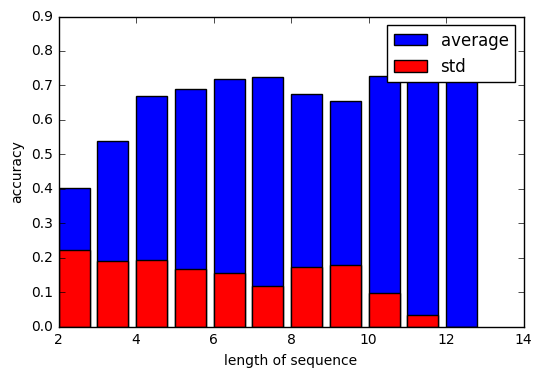

In [13]:
plt.bar(map(lambda x:x[0],stat),map(lambda x:x[1][1],stat),color = 'blue')
plt.bar(map(lambda x:x[0],stat),map(lambda x:x[1][2],stat),color = 'red')
plt.legend(['average','std'])
plt.xlabel('length of sequence')
plt.ylabel('accuracy')